# MHKiT Power Module  
This example will demonstrate the MHKiT Power Module functionality compute power, instantaneous frequency, and harmonics from time series of voltage and current.

We will begin by reading in timeseries data of measured three phase (a,b,and,c) voltage and current. The IEC TS 62600-30 requires that you perform power quality assessments on a minimum of 10-min timseries data, but for this example we will only look at a fraction of that. 


In [2]:
import numpy as np
import pandas as pd
from mhkit import power, utils

# Read in timeseries data of voltage (V) and current (I)
data = pd.read_csv('data/2020224_181521_PowRaw.csv',skip_blank_lines=True,index_col='Time_UTC') 
# Convert the time index to type "datetime" 
data.index=pd.to_datetime(data.index)
# Display the data
data

,MODAQ_Va_V,MODAQ_Vb_V,MODAQ_Vc_V,MODAQ_Ia_I,MODAQ_Ib_I,MODAQ_Ic_I
Time_UTC,,,,,,
2020-02-24 18:15:21.499998208,10652.764496,-8499.446320,-1850.166138,-23.213654,19.219666,4.023438
2020-02-24 18:15:21.500018208,10691.122620,-8428.702576,-1927.626526,-23.404846,19.181671,4.289856
2020-02-24 18:15:21.500038209,10732.961151,-8364.997162,-2001.269318,-23.493042,19.033966,4.478912
2020-02-24 18:15:21.500058210,10775.892639,-8304.582245,-2071.241791,-23.680115,18.917847,4.858246
2020-02-24 18:15:21.500078210,10818.297028,-8248.074066,-2138.016785,-23.737946,18.702087,5.092468
...,...,...,...,...,...,...
2020-02-24 18:15:21.659899962,-11156.280273,3761.971924,7052.360229,24.501648,-8.213348,-16.351318
2020-02-24 18:15:21.659919962,-11136.750458,3657.195374,7126.638641,24.455872,-8.047028,-16.470337
2020-02-24 18:15:21.659939962,-11115.166504,3550.678619,7200.568237,24.535980,-7.887268,-16.733246


## Power Characteristics 
The MHKiT `power.characteristics` module can be used to compute basic quantities of interest from voltage and current time series. In this example we will calculate active AC power and instantneous frequency ( using the loaded voltage and current timeseries.

To compute the active AC power, we will need the power factor. Power factor describes the efficency of the energy device. 


[Text(0, 0.5, 'Power [W]'), Text(0.5, 0, 'Time')]

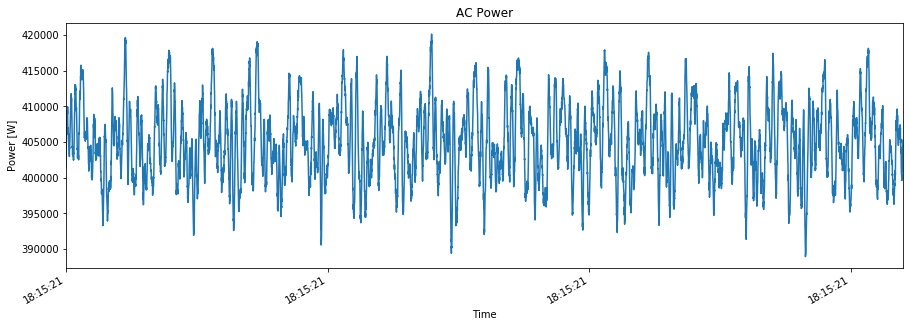

In [3]:
# First seperate the voltage and current timeseries into seperate dataFrames
voltage = data[['MODAQ_Va_V', 'MODAQ_Vb_V', 'MODAQ_Vc_V']]
current = data[['MODAQ_Ia_I','MODAQ_Ib_I','MODAQ_Ic_I']]

# Set the power factor for the system
power_factor = 0.96 

# Compute the instantaneous AC power in watts
ac_power = power.characteristics.ac_power_three_phase(voltage, current, power_factor) 
# Display the result
ac_power.Power.plot(figsize=(15,5),title='AC Power').set(xlabel='Time',ylabel='Power [W]')

### Instantaneous Frequency

Using the 3 phase voltage measurements we can compute the instantaneous frequency of the voltage timeseries. The time-varying instantaneous frequency is a required metric for power quality assessments. 

[Text(0, 0.5, 'Frequency [Hz]'), Text(0.5, 0, 'Time [s]')]

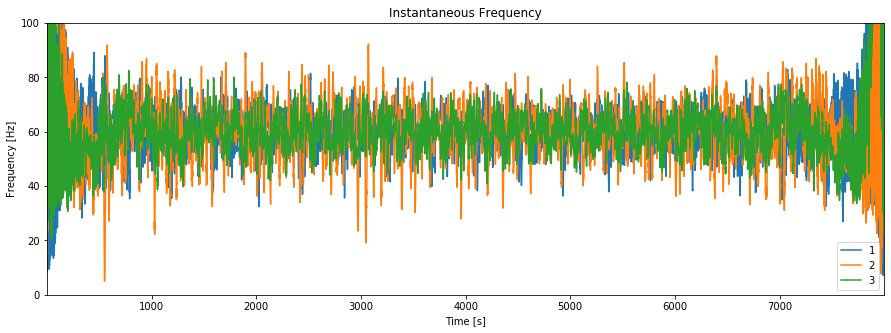

In [5]:
# Compute the instantaneous frequency
inst_freq = power.characteristics.instantaneous_frequency(voltage) 
# Display the result
inst_freq.plot(figsize=(15,5), ylim=(0,100),title='Instantaneous Frequency').set(xlabel='Time [s]',ylabel='Frequency [Hz]')


## Power Quality
The `power.quality` module can be used to compute harmonics of current and voltage and current distortions following IEC TS 62600-30 and IEC 61000-4-7. Harmonics and harmonic distortion are required as part of a power quality assessment and characterize the stability of the power being produced. 

[Text(0, 0.5, 'Harmonic Amplitude'), Text(0.5, 0, 'Frequency [Hz]')]

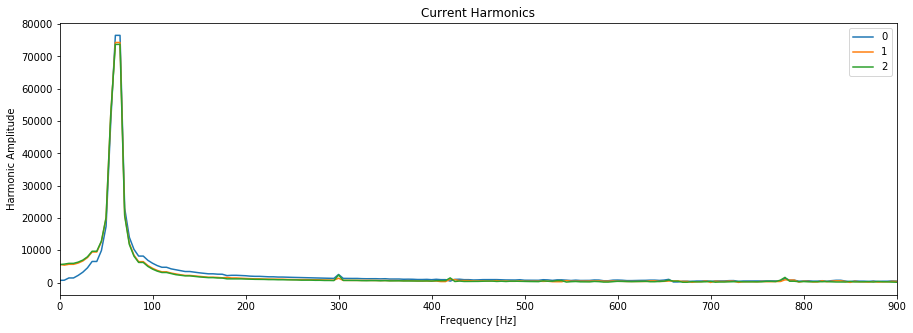

In [6]:
# Set the nominal sampling frequency
sample_freq = 50000   #[Hz]

# Set the frequency of the grid the device would be conected to
grid_freq = 60        #[Hz] 
# Set the rated current of the device
rated_current = 18.8  # [Amps]

# Calculate the harmonics
harmonics = power.quality.harmonics(current, sample_freq, grid_freq)

# Display the results
harmonics.plot(figsize=(15,5),xlim=(0,900),title='Current Harmonics').set(ylabel='Harmonic Amplitude',xlabel='Frequency [Hz]')


### Harmonic Subgroups
Describe what the subgroups are and why we want to calculate them

The harmonic subgroups calculations are based on IEC TS 62600-30. We can clculate them using our grid frequency and harmonics.

In [19]:
# Calcualte Harmonic Subgroups
h_s = power.quality.harmonic_subgroups(harmonics,grid_freq) 
# Display the results
h_s.head()

,0,1,2
1,987.703268,7795.389201,7967.021150
61,119044.431599,117220.150789,116508.081331
121,7480.704280,5165.933181,4825.913942
181,4030.246664,2592.047198,2140.361043
241,2909.863158,1749.822139,1481.656536


### Total Harmonic Current Distortion

Compute the THCD from harmonic subgroups and rated current for the device

In [39]:
#Finally we can compute the total harmonic current distortion as a percentage 
THCD=power.quality.total_harmonic_current_distortion(h_s,rated_current) 
print('Channel  THCD')
print(THCD.to_string())

Channel  THCD
0    8.972511
1    6.096617
2    5.929491
